# 최종5. Fine Tuning, Evaluation

# Index
### 1. 학습을 위한 준비, Pipeline 구성
### 2. Grid Search For 선정된 모델 (Extra Trees, MLP)
### 3. Learning Curve, Confusion Matrix
### 4. 최종 Test 진행 및 Feedback

# 1. 학습을 위한 준비, Pipeline 구성

### 1-0. Library import

In [1]:
# import library for 학습
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import FunctionTransformer
import pickle

from sklearn import datasets
import time

from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2

np.random.seed(42)

### 1-1. Centering 함수 정의

In [2]:
def center_image(image):
    img_reshaped = image.reshape(28, 28)
    non_empty_rows = np.where(img_reshaped.any(axis=1))[0]
    non_empty_cols = np.where(img_reshaped.any(axis=0))[0]

    # 예외 처리: 이미지에 아무것도 없는 경우 pass
    if len(non_empty_rows) == 0 or len(non_empty_cols) == 0:
        return img_reshaped.reshape(-1)

    top, bottom = non_empty_rows[0], non_empty_rows[-1]
    left, right = non_empty_cols[0], non_empty_cols[-1]
    center_y, center_x = (top + bottom) // 2, (left + right) // 2
    shift_y, shift_x = 14 - center_y, 14 - center_x
    shifted_img = np.roll(img_reshaped, shift_x, axis=1)
    shifted_img = np.roll(shifted_img, shift_y, axis=0)
    return shifted_img.reshape(-1)

### 1-2. 정사각형으로 확대 함수 정의

In [3]:
def enlarge_image_to_square(image):
    img_reshaped = image.reshape(28, 28)
    non_empty_rows = np.where(img_reshaped.any(axis=1))[0]
    non_empty_cols = np.where(img_reshaped.any(axis=0))[0]

    # 이미지에 아무것도 없는 경우 28x28의 빈 이미지로 확장
    if len(non_empty_rows) == 0 or len(non_empty_cols) == 0:
        enlarged_image = np.zeros((28, 28), dtype=np.uint8)
        return enlarged_image.flatten()

    # 가장 작은 정사각형의 좌표 찾기
    top, bottom = non_empty_rows[0], non_empty_rows[-1]
    left, right = non_empty_cols[0], non_empty_cols[-1]
    width = right - left + 1
    height = bottom - top + 1

    # 가장 작은 정사각형 생성
    max_side = max(width, height)
    square_image = np.zeros((max_side, max_side), dtype=np.uint8)
    start_row = (max_side - height) // 2
    start_col = (max_side - width) // 2
    square_image[start_row:start_row + height, start_col:start_col + width] = img_reshaped[top:bottom + 1, left:right + 1]

    # 정사각형 이미지를 28x28로 resize
    enlarged_image = Image.fromarray(square_image.astype('uint8'))
    enlarged_image = enlarged_image.resize((28, 28), Image.BICUBIC)

    # 확대된 이미지를 배열로 변환
    enlarged_data = np.array(enlarged_image).flatten()

    return enlarged_data

### 1-3. Tight bound로 확대 함수 정의

In [42]:
def enlarge_image_with_boundary_box(image):
    img_reshaped = image.reshape(28, 28)
    non_empty_rows = np.where(img_reshaped.any(axis=1))[0]
    non_empty_cols = np.where(img_reshaped.any(axis=0))[0]

    # 이미지에 아무것도 없는 경우 pass
    if len(non_empty_rows) == 0 or len(non_empty_cols) == 0:
        return img_reshaped.reshape(-1)

    top, bottom = non_empty_rows[0], non_empty_rows[-1]
    left, right = non_empty_cols[0], non_empty_cols[-1]
    
    # boundary box 생성 후 이미지 확대
    enlarged_image = img_reshaped[top:bottom + 1, left:right + 1]
    enlarged_image = Image.fromarray(enlarged_image.astype('uint8'))
    enlarged_image = enlarged_image.resize((28, 28), Image.BICUBIC)
    
    # 확대된 이미지를 배열로 변환
    enlarged_data = np.array(enlarged_image).flatten()
    
    return enlarged_data

### 1-4. Pipeline을 위한 Class 정의

In [43]:
from sklearn.base import TransformerMixin

# 이미지를 중앙화하는 변환기 클래스 정의
class ImageCenteringTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # 이 경우에는 학습이 필요 없으므로 fit 메서드에서 아무 작업도 하지 않습니다.
        return self

    def transform(self, X):
        return np.apply_along_axis(center_image, 1, X)

# 이미지를 정사각형으로 확대하는 변환기 클래스 정의
class ImageEnlargingTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # 이 경우에도 학습이 필요 없으므로 fit 메서드에서 아무 작업도 하지 않습니다.
        return self

    def transform(self, X):
        return np.apply_along_axis(enlarge_image_to_square, 1, X)

# 이미지를 tight boundary로 확대하는 변환기 클래스 정의    
class TightImageEnlargingTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # 이 경우에도 학습이 필요 없으므로 fit 메서드에서 아무 작업도 하지 않습니다.
        return self

    def transform(self, X):
        return np.apply_along_axis(enlarge_image_with_boundary_box, 1, X)

### 1-5. Denoise 함수 정의

In [5]:
def denoise_with_max(X):
    # Assuming X is a 3000x784 MNIST-like dataset
    threshold = 0.5  # Threshold setting #0.66
    
    # Create an empty array to store processed images
    X_processed = np.zeros_like(X)
    
    # Process each image in the dataset
    for i in range(X.shape[0]):
        max_val = X[i].max()  # Calculate the maximum value within each image
        # Values below the threshold are set to 0, values above are set to 1
        X_processed[i] = (X[i] > threshold * max_val).astype(int)
    
    return X_processed

### 1-6. Noised, Shifted된 Combined Data (class15) 사용 (for 학습, 검증)

In [59]:
filename = 'Noised_Shifted_Handmade_Perfect_Data_with_Validation_with_MNIST.pkl'
with open(filename, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [62]:
print(X_train.shape, y_train.shape)

(59612, 784) (59612,)


# 2. Grid Search For 선정된 모델 (Extra Trees, MLP)

## 2-1. Extra Trees Grid Search

In [44]:
# 파이프라인 생성: Normalizer -> Extra Trees 모델
extra_trees_pipeline = Pipeline([
    ('denoise', FunctionTransformer(denoise_with_max)),  # Denoising step
    ('image_centering', ImageCenteringTransformer()),  # 이미지 중앙화
    ('image_enlarging', TightImageEnlargingTransformer()),
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('extra_trees', ExtraTreesClassifier())  # Extra Trees 모델
])

# Extra Trees의 그리드 서치를 위한 매개변수 그리드
extra_trees_param_grid = {
    'extra_trees__n_estimators': [100,200,300], # 250
    'extra_trees__max_depth': [10,20],
    # 'extra_trees__criterion': ['gini'],
    # 'extra_trees__min_samples_split': range (2,12,2), # 2
    # 'extra_trees__min_samples_leaf': [1, 2, 4], # 1
}

# 측정 시작
start_time = time.time()

# Create the GridSearchCV object
extra_trees_grid_search = GridSearchCV(extra_trees_pipeline, extra_trees_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
extra_trees_grid_search.fit(X_train, y_train)

# 측정 종료
end_time = time.time()

# 최적의 Extra Trees 모델 획득
best_extra_trees_model = extra_trees_grid_search.best_estimator_

# 최적의 모델로 테스트 데이터에 대한 예측
extra_trees_predictions = best_extra_trees_model.predict(X_test)

# 정확도 평가
extra_trees_accuracy = accuracy_score(y_test, extra_trees_predictions)

print(f"\nBest Extra Trees Model: {best_extra_trees_model}")
print(f"Extra Trees search time: {end_time - start_time} seconds")
print("Extra Trees accuracy with Normalizer using Pipeline: ", extra_trees_accuracy)



Best Extra Trees Model: Pipeline(steps=[('denoise',
                 FunctionTransformer(func=<function denoise_with_max at 0x157952ca0>)),
                ('image_centering',
                 <__main__.ImageCenteringTransformer object at 0x157979910>),
                ('image_enlarging',
                 <__main__.TightImageEnlargingTransformer object at 0x150df3590>),
                ('normalizer', Normalizer()),
                ('extra_trees',
                 ExtraTreesClassifier(max_depth=20, n_estimators=300))])
Extra Trees search time: 415.70371294021606 seconds
Extra Trees accuracy with Normalizer using Pipeline:  0.9281818181818182


In [45]:
start_time = time.time()
# 최적의 모델로 테스트 데이터에 대한 예측
extra_trees_predictions = best_extra_trees_model.predict(X_test)
# 정확도 평가
extra_trees_accuracy = accuracy_score(y_test, extra_trees_predictions)
end_time = time.time()

print(f"Extra Trees prediction time: {end_time - start_time} seconds")
print("Extra Trees accuracy with Normalizer using Pipeline: ", extra_trees_accuracy)

Extra Trees prediction time: 0.8703958988189697 seconds
Extra Trees accuracy with Normalizer using Pipeline:  0.9281818181818182


## 2-2. MLP Grid Search

In [14]:
# 파이프라인 생성: Normalizer -> MLP 모델
mlp_pipeline = Pipeline([
    ('denoise', FunctionTransformer(denoise_with_max)),  # Denoising step
    ('image_centering', ImageCenteringTransformer()),  # 이미지 중앙화
    ('image_enlarging', ImageEnlargingTransformer()),  # 이미지 정사각형으로 확대
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('mlp', MLPClassifier())  # MLP 모델
])

# MLP의 그리드 서치를 위한 매개변수 그리드
mlp_param_grid = {
    'mlp__max_iter': [500, 1000, 2000],  # 추후에는 [500, 1000] 으로 진행
    # 'max_iter': range(900, 1100, 50),  # 900: 0.966~7
    # 'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],  # (100,100)
    # 'activation': ['tanh','relu'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1]  # Note the change from 'alpha' to 'mlp__alpha'
}

# 측정 시작
start_time = time.time()

# Create GridSearchCV
mlp_grid_search = GridSearchCV(mlp_pipeline, mlp_param_grid, cv=5, scoring='accuracy')
mlp_grid_search.fit(X_train, y_train)

end_time = time.time()

# 최적의 MLP 모델 획득
best_mlp_model = mlp_grid_search.best_estimator_

# 최적의 모델로 테스트 데이터에 대한 예측
mlp_predictions = best_mlp_model.predict(X_test)

# 정확도 평가
mlp_accuracy = accuracy_score(y_test, mlp_predictions)

print(f"\nBest MLP Model: {best_mlp_model}")
print(f"MLP search time: {end_time - start_time} seconds")
print("MLP accuracy with Normalizer using Pipeline: ", mlp_accuracy)


Best MLP Model: Pipeline(steps=[('denoise',
                 FunctionTransformer(func=<function denoise_with_max at 0x157952ca0>)),
                ('image_centering',
                 <__main__.ImageCenteringTransformer object at 0x157a64110>),
                ('image_enlarging',
                 <__main__.ImageEnlargingTransformer object at 0x151a807d0>),
                ('normalizer', Normalizer()),
                ('mlp', MLPClassifier(alpha=0.01, max_iter=2000))])
MLP search time: 8017.841265201569 seconds
MLP accuracy with Normalizer using Pipeline:  0.9386868686868687


In [25]:
start_time = time.time()
# 최적의 모델로 테스트 데이터에 대한 예측
mlp_predictions = best_mlp_model.predict(X_test)

# 정확도 평가
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
end_time = time.time()
print(f"MLP prediction time: {end_time - start_time} seconds")
print("MLP accuracy with Normalizer using Pipeline: ", mlp_accuracy)

MLP prediction time: 0.47452807426452637 seconds
MLP accuracy with Normalizer using Pipeline:  0.9386868686868687


## 2-3. Voting Classifier with (Best Extra-Trees model, Best MLP model)

In [67]:
# voting_soft_hard // all
named_estimators = [
    ("extra_trese_pipeline", best_extra_trees_model),
    ("mlp_pipeline", best_mlp_model)]

from sklearn.ensemble import VotingClassifier

start_time = time.time()
soft_voting_clf = VotingClassifier(named_estimators, voting='soft')
soft_voting_clf.fit(X_train, y_train)
end_time = time.time()
print(f"Soft Voting search time: {end_time - start_time} seconds")
start_time = time.time()
soft_score = soft_voting_clf.score(X_test, y_test)
end_time = time.time()
print(f"Soft Voting prediction time: {end_time - start_time} seconds")
print("Soft Voting accuracy: ", soft_score)

start_time = time.time()
hard_voting_clf = VotingClassifier(named_estimators, voting='hard')
hard_voting_clf.fit(X_train, y_train)
end_time = time.time()
print(f"Hard Voting search time: {end_time - start_time} seconds")
start_time = time.time()
hard_score = hard_voting_clf.score(X_test, y_test)
end_time = time.time()
print(f"Hard Voting prediction time: {end_time - start_time} seconds")
print("Hard Voting accuracy: ", hard_score)

Soft Voting search time: 197.06340909004211 seconds
Soft Voting prediction time: 1.6197288036346436 seconds
Soft Voting accuracy:  0.9422222222222222
Hard Voting search time: 233.40779185295105 seconds
Hard Voting prediction time: 1.6598498821258545 seconds
Hard Voting accuracy:  0.9305050505050505


#  3. Learning Curve, Confusion Matrix (Extra-Trees, MLP)

##  3-1. Learning Curve (Extra-Trees, MLP)

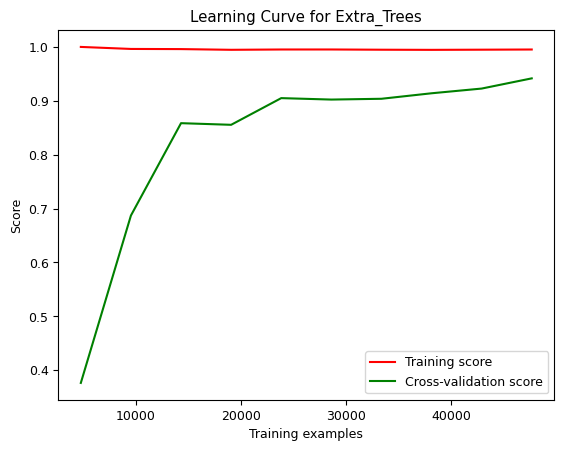

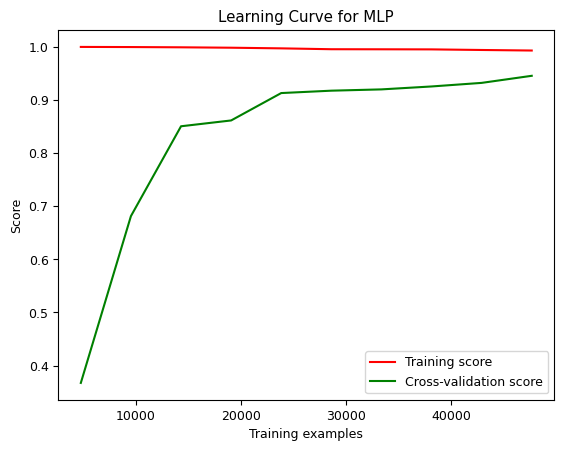

In [66]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Extra Trees 파이프라인 생성: Normalizer -> Extra Trees 모델
extra_trees_pipeline = Pipeline([
    ('denoise', FunctionTransformer(denoise_with_max)),  # Denoising step
    ('image_centering', ImageCenteringTransformer()),  # 이미지 중앙화
    ('image_enlarging', TightImageEnlargingTransformer()),  # 이미지 정사각형으로 확대
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('extra_trees', ExtraTreesClassifier(max_depth=20, n_estimators=300))  # Extra Trees 모델
])

# MLP 파이프라인 생성: Normalizer -> MLP 모델
mlp_pipeline = Pipeline([
    ('denoise', FunctionTransformer(denoise_with_max)),  # Denoising step
    ('image_centering', ImageCenteringTransformer()),  # 이미지 중앙화
    ('image_enlarging', ImageEnlargingTransformer()),  # 이미지 정사각형으로 확대
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('mlp', MLPClassifier(max_iter=2000, alpha=0.01))  # MLP 모델
])


# 모델 리스트
models = [
    ("Extra_Trees", extra_trees_pipeline),
    ("MLP", mlp_pipeline),
]

for name, clf in models:
    train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.title(f"Learning Curve for {name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")

    plt.legend(loc="best")
    plt.show()


## 3-2. Confusion Matrix (Extra-Trees, MLP)

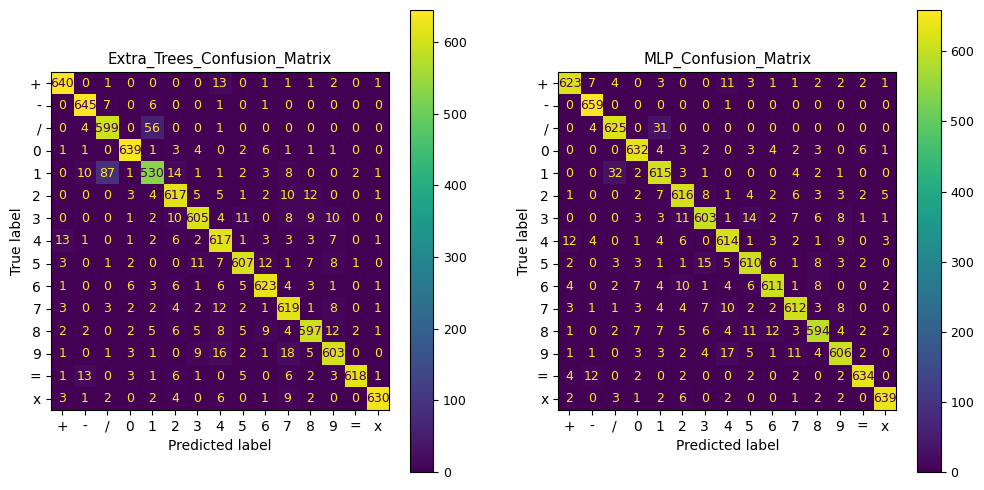

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
mlp_predictions = best_mlp_model.predict(X_test)
extra_trees_predictions = best_extra_trees_model.predict(X_test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_test, extra_trees_predictions, ax=axs[0])
axs[0].set_title("Extra_Trees_Confusion_Matrix")

plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_test, mlp_predictions, ax=axs[1])
axs[1].set_title("MLP_Confusion_Matrix")
plt.show()

# 4. 최종 Test 진행 및 Feedback

## 4-1. Original Data에 대한 Test 진행 (MLP, Extra-Trees, Voting)

In [28]:
import pickle
# 미리 피클 라이브러리를 활용해 저장해둔 MNIST 불러오기
# 매번 fetch 하기 오래 걸려서 채택
from sklearn.model_selection import train_test_split
filename = 'mnist_data.pkl'
with open(filename, 'rb') as f:
    mnist = pickle.load(f)

X_original = mnist.data.astype('float32')
X_original = X_original/255.0
y_original = mnist.target

o_X_train, o_X_test, o_y_train, o_y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)
print(o_X_train.shape, o_X_test.shape, o_y_train.shape, o_y_test.shape)

(56000, 784) (14000, 784) (56000,) (14000,)


In [68]:
# 학습, 검증 데이터 정의
X_t1=o_X_test # 테스트 data 1
y_t1=o_y_test # 테스트 label 1

# 모델 리스트와 이름
models = [
    #("KNN", best_knn_model),
    #("SVM", best_svm_model),
    ("Extra Trees", best_extra_trees_model),
    #("Softmax Regression", best_softmax_model),
    #("Decision Tree", best_decision_tree_model),
    #("Random Forest", best_random_forest_model),
    ("MLP", best_mlp_model),
    ("Hard Voting", hard_voting_clf),
    ("Soft Voting", soft_voting_clf)
]

for name, clf in models:
    # 테스트
    start_pred_time = time.time()
    prediction = clf.predict(X_t1)
    accuracy  = accuracy_score(y_t1, prediction)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time
    print(f"{name}: // 예측 시간 : {pred_time:.5f} // Accuracy: {accuracy:.5f}")

Extra Trees: // 예측 시간 : 1.69720 // Accuracy: 0.95264
MLP: // 예측 시간 : 0.59328 // Accuracy: 0.96271
Hard Voting: // 예측 시간 : 2.06655 // Accuracy: 0.94907
Soft Voting: // 예측 시간 : 2.25069 // Accuracy: 0.96500


## 4-2. Team Handmade Data에 대한 Test 진행

In [31]:
filename = 'Handmade_Team_Test.pkl'
with open(filename, 'rb') as f:
    t_X_test, t_y_test, = pickle.load(f)

t_y_test=t_y_test.astype(str)

print("t_X_test shape:", t_X_test.shape)
print("t_y_test shape:", t_y_test.shape)

print(np.unique(t_y_test))

t_X_test shape: (400, 784)
t_y_test shape: (400,)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [69]:
# 학습, 검증 데이터 정의
X_t1=t_X_test # 테스트 data 1
y_t1=t_y_test # 테스트 label 1

# 모델 리스트와 이름
models = [
    #("KNN", best_knn_model),
    #("SVM", best_svm_model),
    ("Extra Trees", best_extra_trees_model),
    #("Softmax Regression", best_softmax_model),
    #("Decision Tree", best_decision_tree_model),
    #("Random Forest", best_random_forest_model),
    ("MLP", best_mlp_model),
    ("Hard Voting", hard_voting_clf),
    ("Soft Voting", soft_voting_clf)
]

for name, clf in models:
    # 테스트
    start_pred_time = time.time()
    prediction = clf.predict(X_t1)
    accuracy  = accuracy_score(y_t1, prediction)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time
    print(f"{name}: // 예측 시간 : {pred_time:.5f} // Accuracy: {accuracy:.5f}")

Extra Trees: // 예측 시간 : 0.08964 // Accuracy: 0.84500
MLP: // 예측 시간 : 0.02795 // Accuracy: 0.82750
Hard Voting: // 예측 시간 : 0.35179 // Accuracy: 0.80000
Soft Voting: // 예측 시간 : 0.13811 // Accuracy: 0.84750


## 4-3. 최종 Test Data에 대한 Test 진행

In [70]:
filename = 'Perfect_Test.pkl'
with open(filename, 'rb') as f:
    X_t, y_t = pickle.load(f)

print("X_test shape:", X_t.shape)
print("y_test shape:", y_t.shape)

# 모델 리스트와 이름
models = [
    #("KNN", best_knn_model),
    #("SVM", best_svm_model),
    ("Extra Trees", best_extra_trees_model),
    #("Softmax Regression", best_softmax_model),
    #("Decision Tree", best_decision_tree_model),
    #("Random Forest", best_random_forest_model),
    ("MLP", best_mlp_model),
    ("Hard Voting", hard_voting_clf),
    ("Soft Voting", soft_voting_clf)
]

for name, clf in models:
    # 테스트
    start_pred_time = time.time()
    prediction = clf.predict(X_t)
    accuracy  = accuracy_score(y_t, prediction)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time
    print(f"{name}: // 예측 시간 : {pred_time:.5f} // Accuracy: {accuracy:.5f}")

X_test shape: (5478, 784)
y_test shape: (5478,)
Extra Trees: // 예측 시간 : 0.82431 // Accuracy: 0.91201
MLP: // 예측 시간 : 0.23394 // Accuracy: 0.92150
Hard Voting: // 예측 시간 : 0.96035 // Accuracy: 0.91822
Soft Voting: // 예측 시간 : 1.12011 // Accuracy: 0.92680


## 4-4. Noised, Shifted 최종 Test Data에 대한 Test 진행

In [71]:
filename = 'Noised_Shifted_Perfect_Test.pkl'
with open(filename, 'rb') as f:
    X_t, y_t = pickle.load(f)

print("X_test shape:", X_t.shape)
print("y_test shape:", y_t.shape)

# 모델 리스트와 이름
models = [
    #("KNN", best_knn_model),
    #("SVM", best_svm_model),
    ("Extra Trees", best_extra_trees_model),
    #("Softmax Regression", best_softmax_model),
    #("Decision Tree", best_decision_tree_model),
    #("Random Forest", best_random_forest_model),
    ("MLP", best_mlp_model),
    ("Hard Voting", hard_voting_clf),
    ("Soft Voting", soft_voting_clf)
]

for name, clf in models:
    # 테스트
    start_pred_time = time.time()
    prediction = clf.predict(X_t)
    accuracy  = accuracy_score(y_t, prediction)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time
    print(f"{name}: // 예측 시간 : {pred_time:.5f} // Accuracy: {accuracy:.5f}")

X_test shape: (5478, 784)
y_test shape: (5478,)
Extra Trees: // 예측 시간 : 0.74779 // Accuracy: 0.91201
MLP: // 예측 시간 : 0.23500 // Accuracy: 0.92150
Hard Voting: // 예측 시간 : 1.04238 // Accuracy: 0.91822
Soft Voting: // 예측 시간 : 0.92722 // Accuracy: 0.92680


## 4-5. 최종 모델에 대한 Confusion Matrix

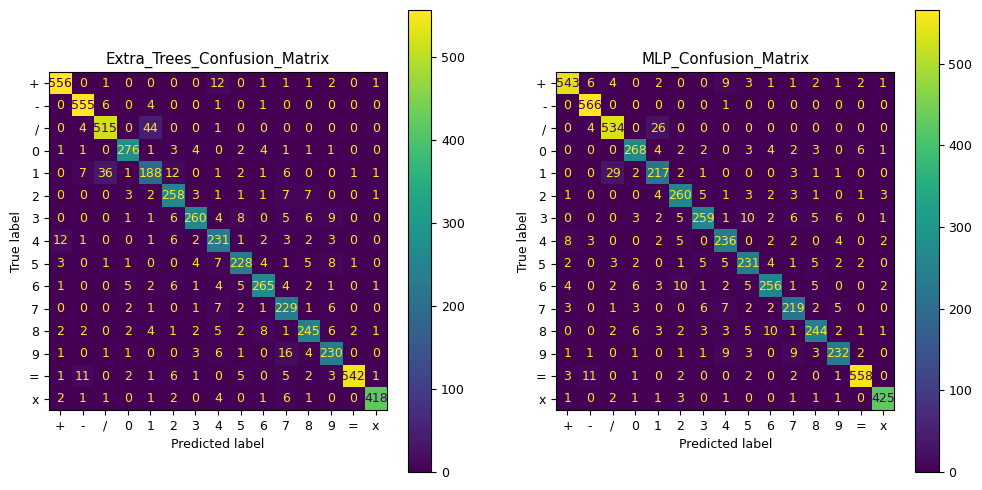

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
mlp_predictions = best_mlp_model.predict(X_t)
extra_trees_predictions = best_extra_trees_model.predict(X_t)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_t, extra_trees_predictions, ax=axs[0])
axs[0].set_title("Extra_Trees_Confusion_Matrix")

plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_t, mlp_predictions, ax=axs[1])
axs[1].set_title("MLP_Confusion_Matrix")
plt.show()

# [EOF]